# Tuning 

- Author: Israel Oliveira [\[e-mail\]](mailto:'Israel%20Oliveira%20'<prof.israel@gmail.com>)

In [1]:
%load_ext watermark

In [2]:
import pandas as pd
import numpy as np
from random_forest_mc.model import RandomForestMC
from random_forest_mc.utils import LoadDicts, dump_file_json, load_file_json
from tqdm.notebook import tqdm
from datetime import datetime
from collections import Counter, defaultdict
from glob import glob
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [3]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

In [4]:
import functools
import operator
def flat(a):
    return functools.reduce(operator.iconcat, a, [])

In [5]:
# Run this cell before close.
%watermark -d --iversion -b -r -g -m -v
!cat /proc/cpuinfo |grep 'model name'|head -n 1 |sed -e 's/model\ name/CPU/'
!free -h |cut -d'i' -f1  |grep -v total

Python implementation: CPython
Python version       : 3.11.10
IPython version      : 8.27.0

Compiler    : GCC 10.2.1 20210110
OS          : Linux
Release     : 6.8.0-44-generic
Machine     : x86_64
Processor   : 
CPU cores   : 20
Architecture: 64bit

Git hash: c059562925baa1f6df6c5a0b72c7f02a144c8790

Git repo: https://github.com/ysraell/random-forest-mc-utils.git

Git branch: main

pandas: 2.2.2
numpy : 1.26.4

CPU	: 12th Gen Intel(R) Core(TM) i7-12700
Mem:            15G
Swap:          3.7G


In [6]:
dataset_path = '/work/tmp/credit-card-fraud-prediction'

In [7]:
!ls $dataset_path

model_tuning2_64trees_20240914_2326.json  test.csv
model_tuning_320trees_20240914_2145.json  train.csv
sample_submission.csv			  trees_metrcis_sim_20240915_1425.json


In [8]:
df = pd.read_csv(f'{dataset_path}/train.csv')
df = df.drop(columns='Time')
df['Transaction_Amount'] = (df['Transaction_Amount'] * 100).astype(np.uint32)
target_col = 'IsFraud'
df[target_col] = df[target_col].astype(str)
feat_cols = df.columns.to_list()
feat_cols.remove('id')
feat_cols.remove(target_col)
IsFraud_count, Not_IsFraud_count = df[target_col].value_counts()['1'], df[target_col].value_counts()['0']
IsFraud_count, Not_IsFraud_count

(269, 149731)

In [9]:
split_schema = {
    'test': {
        '1': 100,
        '0': 10000,
    },
    'train': {
        '1': 100,
        '0': 50000,
    },
    'val': {
        '1': 69,
        '0': 6900,
    }
}

In [10]:
df_tmp = df.copy()

dfs = {}
for ds_set in split_schema.keys():
    df_set = pd.concat([
        df_tmp.query(f'{target_col} == "{target_val}"').sample(n=split_schema[ds_set][target_val], random_state=42)
        for target_val in ['1', '0']
    ])
    df_tmp = df_tmp.drop(df_set.index).reset_index(drop=True)
    dfs[ds_set] = df_set.reset_index(drop=True)

df_tofit = pd.concat([dfs['train'], dfs['val']])

In [11]:
df_tmp.shape[0], df_tofit.shape[0], dfs['test'].shape[0], df_tmp.shape[0] + df_tofit.shape[0] + dfs['test'].shape[0]

(82831, 57069, 10100, 150000)

In [12]:
batch_train_pclass = split_schema['train']['1']
batch_val_pclass = split_schema['val']['1']
max_depth = None
n_trees = 16
max_discard_trees = 256
min_feature = 2
max_feature = 12

cpu_cores = 8
max_workers = 2*cpu_cores

cls = RandomForestMC(
    n_trees=n_trees, 
    target_col=target_col, 
    max_discard_trees=max_discard_trees,
    batch_train_pclass=batch_train_pclass,
    batch_val_pclass=batch_val_pclass,
    min_feature=min_feature,
    max_feature=max_feature,
    max_depth=max_depth
)
cls

RandomForestMC(len(Forest)=0,n_trees=16,model_version=1.2.0-dev,module_version=1.2.0-dev)

In [13]:
df_test = dfs['test']
y_test = df_test[target_col].astype(int).to_list()
ppy = lambda x: round(100*x, 6)

# Create the model

In [13]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_tuning_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

Planting the forest:   0%|          | 0/16 [00:00<?, ?it/s]

In [20]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

16 Trees


,Pred False,Pred True
False,7574,2426
True,37,63


Acc: 75.6139% 
 F1: 4.8667% 
 FN: 37.0000%
Feat count stats: (6.4375, 2.5973243443975185, 2, 9)


[(9, 7), (6, 2), (2, 2), (5, 2), (7, 1), (4, 1), (3, 1)]

In [19]:
cls.max_feature = 9

In [21]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_tuning_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

Planting the forest:   0%|          | 0/16 [00:00<?, ?it/s]

In [22]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

32 Trees


,Pred False,Pred True
False,8152,1848
True,42,58


Acc: 81.2871% 
 F1: 5.7827% 
 FN: 42.0000%
Feat count stats: (6.34375, 2.4187984491271695, 2, 9)


[(9, 9), (8, 5), (5, 4), (6, 3), (2, 3), (7, 3), (3, 3), (4, 2)]

In [23]:
cls.n_trees = 32

In [24]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_tuning_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

Planting the forest:   0%|          | 0/32 [00:00<?, ?it/s]

In [25]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

64 Trees


,Pred False,Pred True
False,8667,1333
True,45,55


Acc: 86.3564% 
 F1: 7.3925% 
 FN: 45.0000%
Feat count stats: (5.703125, 2.3027136674747473, 2, 9)


[(9, 12), (3, 11), (4, 9), (6, 8), (7, 7), (5, 7), (8, 6), (2, 4)]

In [26]:
cls.n_trees = 64

In [27]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_tuning_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

Planting the forest:   0%|          | 0/64 [00:00<?, ?it/s]

In [28]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

128 Trees


,Pred False,Pred True
False,9027,973
True,56,44


Acc: 89.8119% 
 F1: 7.8782% 
 FN: 56.0000%
Feat count stats: (5.8828125, 2.283162190875574, 2, 9)


[(9, 24), (3, 19), (6, 16), (8, 16), (7, 15), (5, 15), (4, 15), (2, 8)]

In [29]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_tuning_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

Planting the forest:   0%|          | 0/64 [00:00<?, ?it/s]

In [30]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

192 Trees


,Pred False,Pred True
False,9086,914
True,54,46


Acc: 90.4158% 
 F1: 8.6792% 
 FN: 54.0000%
Feat count stats: (5.640625, 2.2502350860984133, 2, 9)


[(5, 31), (9, 28), (3, 28), (8, 24), (7, 22), (4, 22), (6, 21), (2, 16)]

In [31]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_tuning_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

Planting the forest:   0%|          | 0/64 [00:00<?, ?it/s]

In [32]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

256 Trees


,Pred False,Pred True
False,9130,870
True,55,45


Acc: 90.8416% 
 F1: 8.8670% 
 FN: 55.0000%
Feat count stats: (5.5546875, 2.2735180398104937, 2, 9)


[(5, 41), (9, 35), (7, 33), (3, 33), (4, 30), (8, 30), (2, 28), (6, 26)]

In [33]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_tuning_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

Planting the forest:   0%|          | 0/64 [00:00<?, ?it/s]

In [34]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

320 Trees


,Pred False,Pred True
False,9171,829
True,54,46


Acc: 91.2574% 
 F1: 9.4359% 
 FN: 54.0000%
Feat count stats: (5.50625, 2.280342285162471, 2, 9)


[(5, 49), (3, 45), (9, 41), (8, 41), (7, 39), (4, 39), (2, 35), (6, 31)]

# Trees with higher max dephs 

In [38]:
split_with_replace = True
batch_train_pclass = 2000
batch_val_pclass = 100
max_depth = 200
n_trees = 16
max_discard_trees = 256
min_feature = 2
max_feature = 12

cpu_cores = 8
max_workers = 2*cpu_cores

cls = RandomForestMC(
    n_trees=n_trees, 
    target_col=target_col, 
    max_discard_trees=max_discard_trees,
    batch_train_pclass=batch_train_pclass,
    batch_val_pclass=batch_val_pclass,
    min_feature=min_feature,
    max_feature=max_feature,
    max_depth=max_depth,
    split_with_replace=split_with_replace
)
cls

RandomForestMC(len(Forest)=0,n_trees=16,model_version=1.2.0-dev,module_version=1.2.0-dev)

In [39]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_tuning2_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

Planting the forest:   0%|          | 0/16 [00:00<?, ?it/s]

In [40]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

16 Trees


,Pred False,Pred True
False,9987,13
True,97,3


Acc: 98.9109% 
 F1: 5.1724% 
 FN: 97.0000%
Feat count stats: (10.5, 1.620185174601965, 6, 12)


[(12, 5), (11, 5), (10, 3), (6, 1), (9, 1), (8, 1)]

In [41]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_tuning2_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

Planting the forest:   0%|          | 0/16 [00:00<?, ?it/s]

In [42]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

32 Trees


,Pred False,Pred True
False,9992,8
True,99,1


Acc: 98.9406% 
 F1: 1.8349% 
 FN: 99.0000%
Feat count stats: (10.1875, 1.6286017775994228, 6, 12)


[(12, 8), (11, 8), (10, 7), (9, 4), (8, 2), (7, 2), (6, 1)]

In [43]:
cls.n_tree = 64

In [44]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_tuning2_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

Planting the forest:   0%|          | 0/16 [00:00<?, ?it/s]

In [45]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

48 Trees


,Pred False,Pred True
False,9991,9
True,100,0


Acc: 98.9208% 
 F1: 0.0000% 
 FN: 100.0000%
Feat count stats: (10.395833333333334, 1.5644432360711873, 6, 12)


[(12, 15), (11, 12), (10, 8), (9, 7), (8, 3), (7, 2), (6, 1)]

In [46]:
cls.n_tree = 128

In [47]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_tuning2_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

Planting the forest:   0%|          | 0/16 [00:00<?, ?it/s]

In [48]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

64 Trees


,Pred False,Pred True
False,9994,6
True,100,0


Acc: 98.9505% 
 F1: 0.0000% 
 FN: 100.0000%
Feat count stats: (10.421875, 1.434014115821389, 6, 12)


[(11, 19), (12, 17), (10, 12), (9, 10), (8, 3), (7, 2), (6, 1)]

In [66]:
dps = cls.trees2depths
pd.DataFrame(flat(dps), columns=['Depths']).describe()

,Depths
count,30902.000000
mean,10.395541
std,1.226577
min,6.000000
25%,10.000000
50%,10.000000
75%,11.000000
max,17.000000


# Search for the best set of trees

In [14]:
cls = RandomForestMC(target_col=target_col)
cls.process_dataset(df_tofit)

In [15]:
for model_json in glob(f'{dataset_path}/model_*.json'):
    model_dict = load_file_json(model_json)
    cls_tmp = RandomForestMC(target_col=target_col)
    cls_tmp.dict2model(model_dict)
    cls.mergeForest(cls_tmp)
cls

RandomForestMC(len(Forest)=384,n_trees=16,model_version=1.2.0-dev,module_version=1.2.0-dev)

In [78]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

384 Trees


,Pred False,Pred True
False,9753,247
True,70,30


Acc: 96.8614% 
 F1: 15.9151% 
 FN: 70.0000%
Feat count stats: (6.325520833333333, 2.8340883931873586, 2, 12)


[(9, 51),
 (5, 49),
 (3, 45),
 (8, 44),
 (7, 41),
 (4, 39),
 (2, 35),
 (6, 32),
 (11, 19),
 (12, 17),
 (10, 12)]

,Depths
count,90493.000000
mean,9.346071
std,1.236084
min,4.000000
25%,9.000000
50%,9.000000
75%,10.000000
max,17.000000


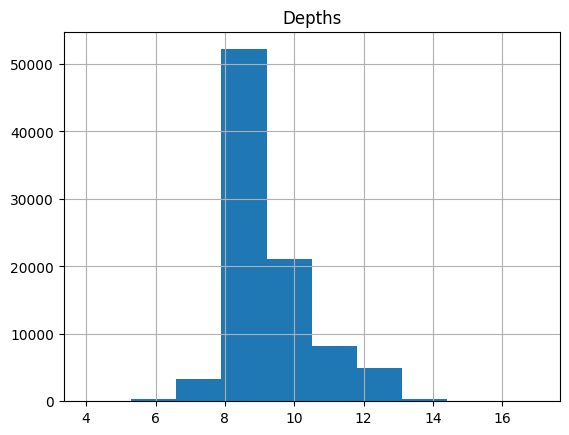

In [79]:
dps = cls.trees2depths
df_dethps = pd.DataFrame(flat(dps), columns=['Depths'])
df_dethps.hist()
df_dethps.describe()

In [114]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)

tp_soft = []
tp_hard = []
final_N = cls.Forest_size
for i in tqdm(range(1,final_N)):
    cls_inc.reset_forest()
    cls_inc.mergeForest(cls, N=i, by="score")
    cls_inc.setSoftVoting(True)
    y_pred_soft = np.array(cls_inc.testForest(df_frauds)).astype(int)
    tp_soft.append(sum(y_pred_soft))
    cls_inc.setSoftVoting(False)
    y_pred_hard = np.array(cls_inc.testForest(df_frauds)).astype(int)
    tp_hard.append(sum(y_pred_hard))

  0%|          | 0/383 [00:00<?, ?it/s]

,0
count,383.000000
mean,15.733681
std,10.006390
min,1.000000
25%,6.000000
50%,18.000000
75%,26.000000
max,30.000000


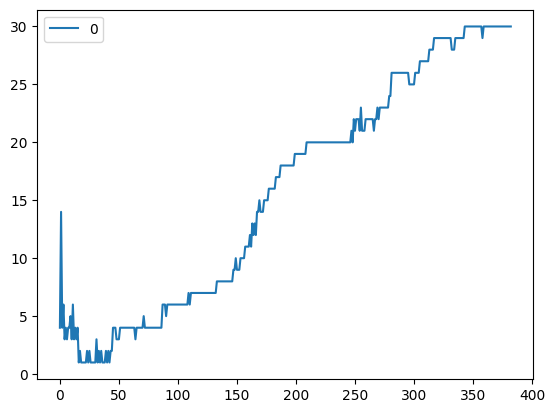

In [115]:
df_soft = pd.DataFrame(tp_soft)
df_soft.plot()
df_soft.describe()

,0
count,383.000000
mean,15.733681
std,10.006390
min,1.000000
25%,6.000000
50%,18.000000
75%,26.000000
max,30.000000


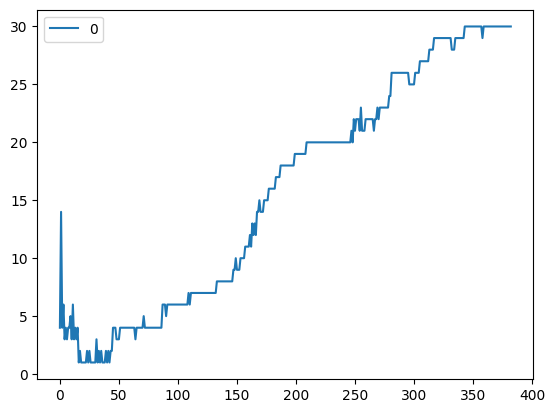

In [116]:
df_hard = pd.DataFrame(tp_hard)
df_hard.plot()
df_hard.describe()

In [117]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)

tp_soft = []
tp_hard = []
final_N = cls.Forest_size
for i in tqdm(range(1,final_N)):
    cls_inc.reset_forest()
    cls_inc.mergeForest(cls, N=i, by="random")
    cls_inc.setSoftVoting(True)
    y_pred_soft = np.array(cls_inc.testForest(df_frauds)).astype(int)
    tp_soft.append(sum(y_pred_soft))
    cls_inc.setSoftVoting(False)
    y_pred_hard = np.array(cls_inc.testForest(df_frauds)).astype(int)
    tp_hard.append(sum(y_pred_hard))

  0%|          | 0/383 [00:00<?, ?it/s]

,0
count,383.000000
mean,30.571802
std,5.429649
min,6.000000
25%,28.000000
50%,30.000000
75%,31.000000
max,73.000000


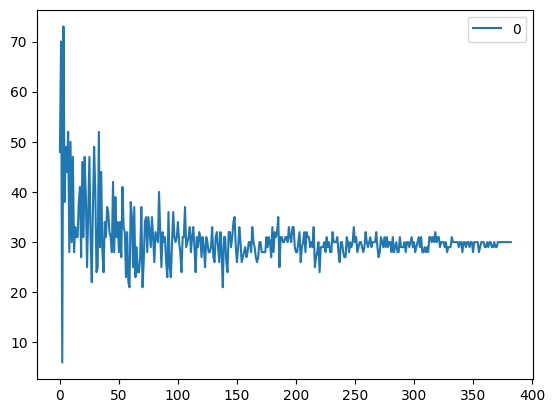

In [118]:
df_soft = pd.DataFrame(tp_soft)
df_soft.plot()
df_soft.describe()

,0
count,383.000000
mean,30.571802
std,5.429649
min,6.000000
25%,28.000000
50%,30.000000
75%,31.000000
max,73.000000


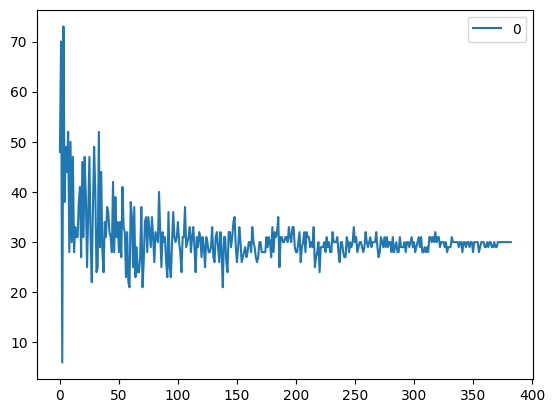

In [119]:
df_hard = pd.DataFrame(tp_hard)
df_hard.plot()
df_hard.describe()

In [140]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)

N_sim = 100

data = []
final_N = cls.Forest_size
for i in tqdm(range(1,final_N)):
    tp = []
    for _ in range(N_sim):
        cls_inc.reset_forest()
        cls_inc.mergeForest(cls, N=i, by="random")
        cls_inc.setSoftVoting(True)
        y_pred_soft = np.array(cls_inc.testForest(df_frauds)).astype(int)
        tp.append(sum(y_pred_soft))
    data.append(tp)

  0%|          | 0/383 [00:00<?, ?it/s]

<Axes: >

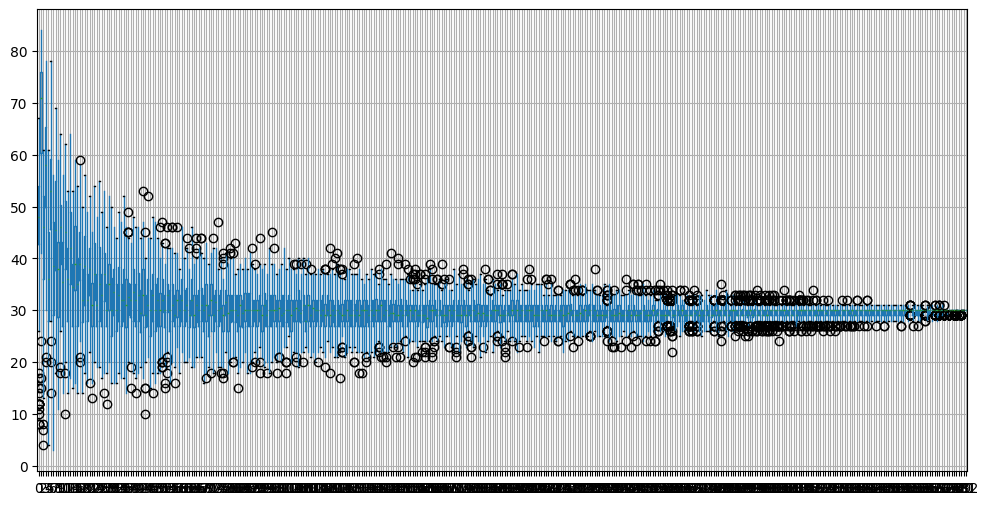

In [141]:
df = pd.DataFrame(data).T

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
from cycler import cycler

rcParams['figure.figsize'] = 12, 6
plt.figure()
df.boxplot()

In [152]:
df.describe().T.sort_values(by='mean', ascending=False).head(20)

,count,mean,std,min,25%,50%,75%,max
1,100.0,66.67,13.664120,15.0,60.25,71.0,76.00,84.0
3,100.0,56.58,12.193872,20.0,50.00,58.0,65.25,78.0
5,100.0,51.61,11.401661,14.0,45.75,53.0,59.25,78.0
7,100.0,45.72,12.043759,18.0,37.75,45.5,55.00,69.0
9,100.0,44.95,9.139077,18.0,39.00,46.0,50.25,64.0
0,100.0,44.43,15.240334,8.0,42.75,48.0,54.00,67.0
11,100.0,43.99,10.299059,10.0,38.00,45.0,51.00,62.0
2,100.0,42.62,12.276100,4.0,36.00,46.0,52.00,61.0
13,100.0,41.66,10.231877,17.0,35.00,42.0,49.00,64.0
15,100.0,40.13,8.959680,16.0,34.00,39.0,46.25,59.0


In [153]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)

N_sim = 1000

data = []
final_N = 10
for i in tqdm(range(1,final_N)):
    tp = []
    for _ in range(N_sim):
        cls_inc.reset_forest()
        cls_inc.mergeForest(cls, N=i, by="random")
        cls_inc.setSoftVoting(True)
        y_pred_soft = np.array(cls_inc.testForest(df_frauds)).astype(int)
        tp.append(sum(y_pred_soft))
    data.append(tp)

  0%|          | 0/9 [00:00<?, ?it/s]

<Axes: >

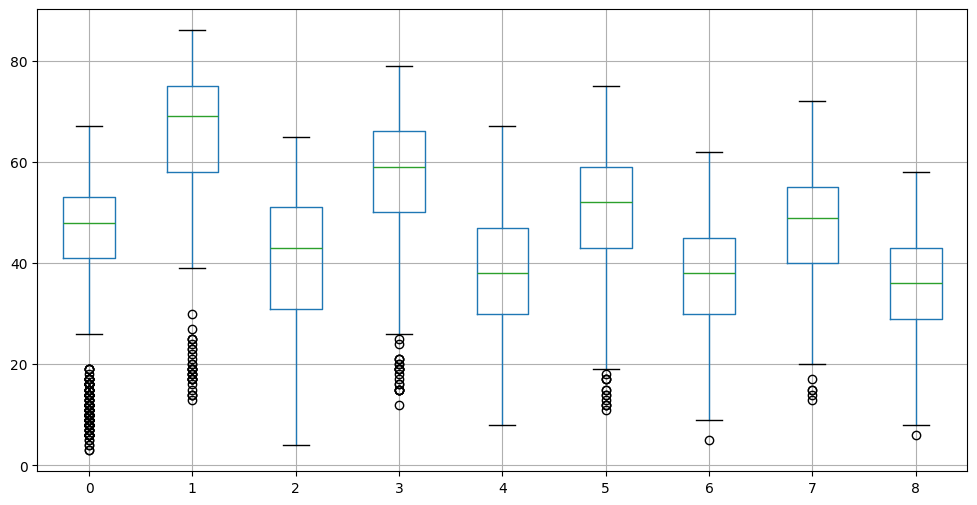

In [154]:
df = pd.DataFrame(data).T

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
from cycler import cycler

rcParams['figure.figsize'] = 12, 6
plt.figure()
df.boxplot()

In [155]:
df.describe().T.sort_values(by='mean', ascending=False).head(20)

,count,mean,std,min,25%,50%,75%,max
1,1000.0,65.720,13.020873,13.0,58.0,69.0,75.0,86.0
3,1000.0,56.452,12.695545,12.0,50.0,59.0,66.0,79.0
5,1000.0,50.123,12.033149,11.0,43.0,52.0,59.0,75.0
7,1000.0,47.330,10.810271,13.0,40.0,49.0,55.0,72.0
0,1000.0,43.161,15.681230,3.0,41.0,48.0,53.0,67.0
2,1000.0,40.058,13.040502,4.0,31.0,43.0,51.0,65.0
4,1000.0,37.983,11.429670,8.0,30.0,38.0,47.0,67.0
6,1000.0,37.221,10.731511,5.0,30.0,38.0,45.0,62.0
8,1000.0,35.321,9.886744,6.0,29.0,36.0,43.0,58.0


In [170]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)

N_sim = 1000

data = []
final_N = 10
for i in tqdm(range(2,final_N+2, 2)):
    tp = []
    for _ in range(1,N_sim):
        cls_inc.reset_forest()
        cls_inc.mergeForest(cls, N=i, by="random")
        cls_inc.setSoftVoting(True)
        y_pred_soft = np.array(cls_inc.testForest(df_frauds)).astype(int)
        tp.append(sum(y_pred_soft))
    data.append(tp)

  0%|          | 0/5 [00:00<?, ?it/s]

<Axes: >

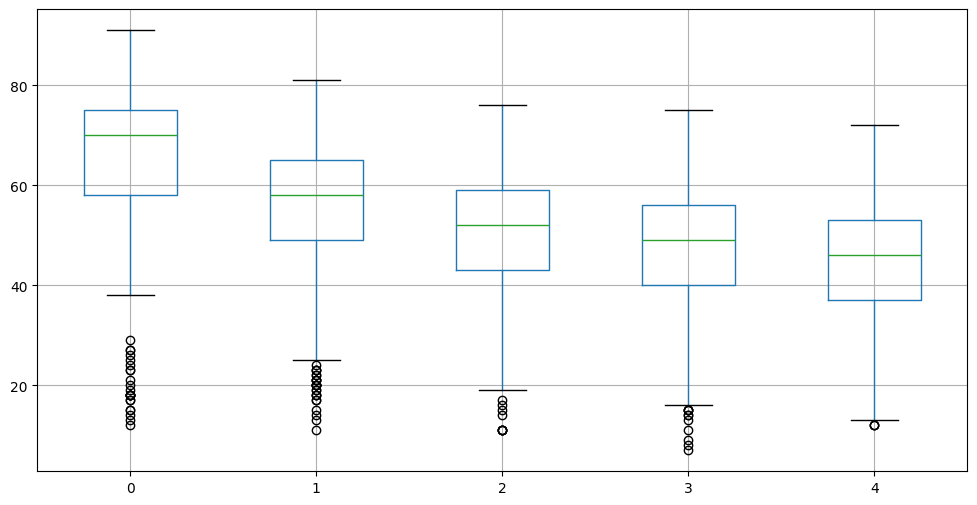

In [171]:
df = pd.DataFrame(data).T
plt.figure()
df.boxplot()

In [172]:
df.describe().T.sort_values(by='mean', ascending=False).head(20)

,count,mean,std,min,25%,50%,75%,max
0,999.0,66.405405,12.678893,12.0,58.0,70.0,75.0,91.0
1,999.0,55.636637,12.714654,11.0,49.0,58.0,65.0,81.0
2,999.0,50.841842,11.631750,11.0,43.0,52.0,59.0,76.0
3,999.0,47.291291,11.557568,7.0,40.0,49.0,56.0,75.0
4,999.0,44.635636,10.614741,12.0,37.0,46.0,53.0,72.0


In [173]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)

N_sim = 20000

data = []
for i in tqdm([2, 4]):
    tp = []
    for _ in range(1,N_sim):
        cls_inc.reset_forest()
        cls_inc.mergeForest(cls, N=i, by="random")
        cls_inc.setSoftVoting(True)
        y_pred_soft = np.array(cls_inc.testForest(df_frauds)).astype(int)
        tp.append(sum(y_pred_soft))
    data.append(tp)

  0%|          | 0/2 [00:00<?, ?it/s]

<Axes: >

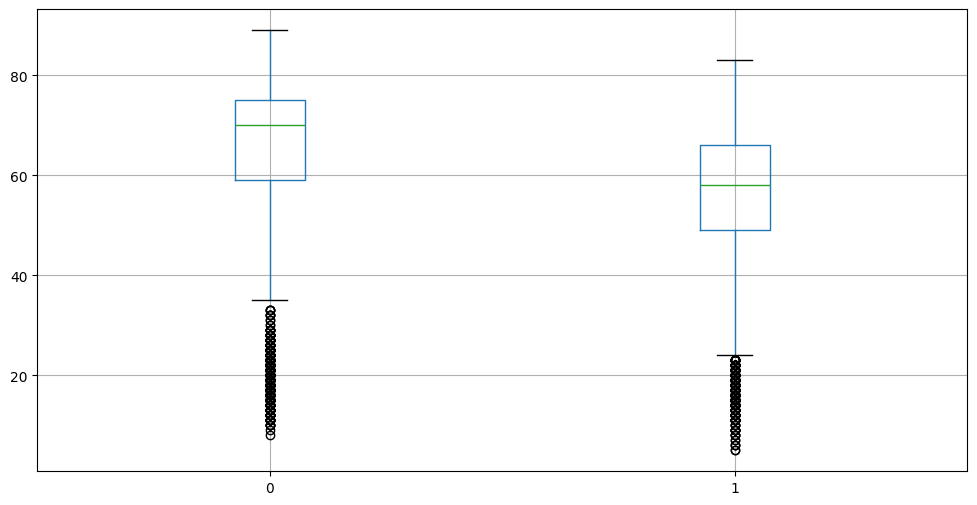

In [174]:
df = pd.DataFrame(data).T
plt.figure()
df.boxplot()

In [175]:
df.describe().T.sort_values(by='mean', ascending=False).head(20)

,count,mean,std,min,25%,50%,75%,max
0,19999.0,66.196510,12.809426,8.0,59.0,70.0,75.0,89.0
1,19999.0,56.033702,12.496267,5.0,49.0,58.0,66.0,83.0


In [178]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
cls_inc.setSoftVoting(True)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)
df_notfrauds = df_test.query(f'{target_col} == "0"').sample(n=100).reset_index(drop=True)
df_mini_test = pd.concat([df_notfrauds, df_frauds], ignore_index=True)
y_test = df_mini_test[target_col].astype(int).to_list()

N_sim = 1000

data_acc = []
data_f1 = []
final_N = 100
for i in tqdm(range(1,final_N)):
    acc = []
    f1 = []
    for _ in range(N_sim):
        cls_inc.reset_forest()
        cls_inc.mergeForest(cls, N=i, by="random")   
        y_pred_soft = np.array(cls_inc.testForest(df_mini_test)).astype(int)
        acc.append(accuracy_score(y_test, y_pred_soft))
        f1.append(f1_score(y_test, y_pred_soft))
    data_acc.append(acc)
    data_f1.append(f1)

  0%|          | 0/99 [00:00<?, ?it/s]

,count,mean,std,min,25%,50%,75%,max
41,1000.0,0.636615,0.022362,0.565,0.62000,0.635,0.65000,0.700
67,1000.0,0.636040,0.019965,0.565,0.62500,0.635,0.65000,0.700
89,1000.0,0.635900,0.017637,0.580,0.62500,0.635,0.64625,0.690
75,1000.0,0.635805,0.018844,0.580,0.62500,0.635,0.65000,0.705
73,1000.0,0.635615,0.020289,0.570,0.62375,0.635,0.65000,0.700
95,1000.0,0.635580,0.017321,0.580,0.62500,0.635,0.64500,0.685
53,1000.0,0.635565,0.022125,0.565,0.62000,0.635,0.65000,0.700
77,1000.0,0.635555,0.019722,0.575,0.62000,0.635,0.65000,0.705
79,1000.0,0.635515,0.019172,0.580,0.62000,0.635,0.65000,0.685
83,1000.0,0.635485,0.018475,0.565,0.62000,0.635,0.65000,0.690


,count,mean,std,min,25%,50%,75%,max
1,1000.0,0.603843,0.069181,0.201681,0.583732,0.618026,0.643850,0.714894
3,1000.0,0.575800,0.073101,0.130841,0.543478,0.590164,0.625561,0.720379
5,1000.0,0.554586,0.075760,0.186441,0.516484,0.568364,0.608247,0.704762
7,1000.0,0.544629,0.077528,0.208696,0.496894,0.558140,0.598885,0.714286
9,1000.0,0.535267,0.080486,0.165138,0.490740,0.545455,0.596328,0.707071
11,1000.0,0.523314,0.080577,0.145455,0.480889,0.533333,0.581024,0.693642
13,1000.0,0.514929,0.076310,0.252101,0.467438,0.522876,0.571429,0.697917
15,1000.0,0.510318,0.076551,0.146789,0.466438,0.516556,0.564772,0.695652
17,1000.0,0.505841,0.073465,0.181818,0.465512,0.516129,0.556962,0.674157
19,1000.0,0.499561,0.075803,0.256410,0.450704,0.510067,0.554054,0.674157


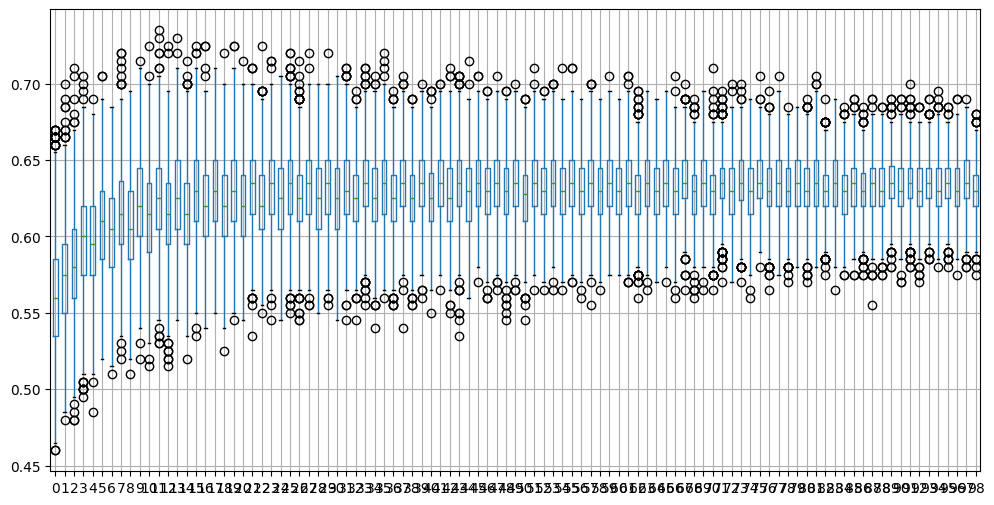

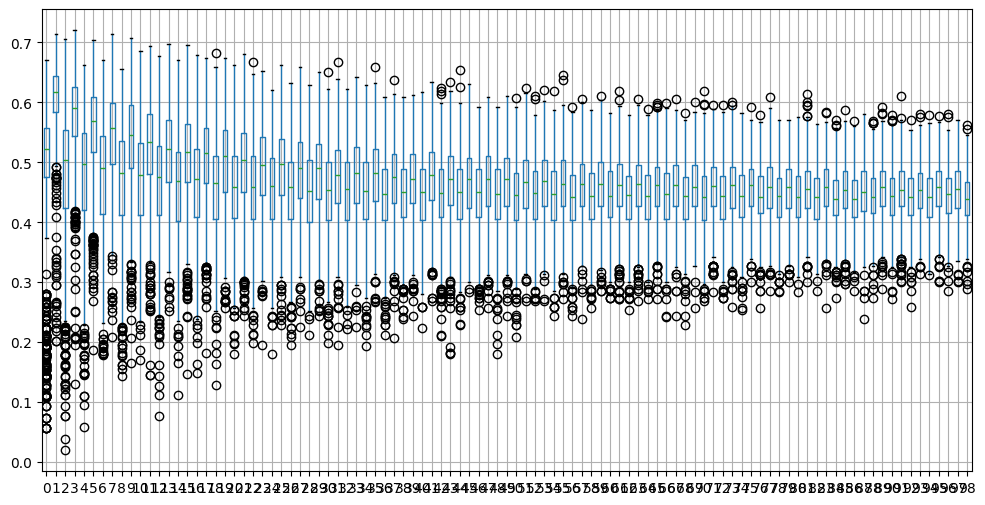

In [179]:
for data in [data_acc, data_f1]:
    df = pd.DataFrame(data).T
    display(df.describe().T.sort_values(by='mean', ascending=False).head(20))
    plt.figure()
    df.boxplot()

In [180]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
cls_inc.setSoftVoting(True)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)
df_notfrauds = df_test.query(f'{target_col} == "0"').sample(n=100).reset_index(drop=True)
df_mini_test = pd.concat([df_notfrauds, df_frauds], ignore_index=True)
y_test = df_mini_test[target_col].astype(int).to_list()

N_sim = 10000

data_acc = []
data_f1 = []
final_N = 10
for i in tqdm(range(1,final_N)):
    acc = []
    f1 = []
    for _ in range(N_sim):
        cls_inc.reset_forest()
        cls_inc.mergeForest(cls, N=i, by="random")   
        y_pred_soft = np.array(cls_inc.testForest(df_mini_test)).astype(int)
        acc.append(accuracy_score(y_test, y_pred_soft))
        f1.append(f1_score(y_test, y_pred_soft))
    data_acc.append(acc)
    data_f1.append(f1)

  0%|          | 0/9 [00:00<?, ?it/s]

,count,mean,std,min,25%,50%,75%,max
7,10000.0,0.600394,0.032757,0.480,0.580,0.600,0.625,0.715
8,10000.0,0.593915,0.031779,0.480,0.570,0.595,0.615,0.735
5,10000.0,0.592820,0.034112,0.475,0.570,0.595,0.615,0.705
6,10000.0,0.589039,0.032797,0.470,0.565,0.590,0.610,0.705
4,10000.0,0.581008,0.033987,0.465,0.560,0.580,0.605,0.710
3,10000.0,0.580780,0.035125,0.465,0.555,0.580,0.605,0.695
2,10000.0,0.569562,0.035125,0.450,0.545,0.570,0.595,0.700
1,10000.0,0.558763,0.035304,0.430,0.535,0.560,0.585,0.680
0,10000.0,0.550148,0.037861,0.435,0.525,0.550,0.580,0.640


,count,mean,std,min,25%,50%,75%,max
1,10000.0,0.593084,0.070272,0.156522,0.571429,0.608333,0.635193,0.716814
3,10000.0,0.565063,0.075198,0.076190,0.533333,0.580645,0.615385,0.724891
5,10000.0,0.546161,0.078421,0.112150,0.508475,0.560000,0.600235,0.719626
7,10000.0,0.533591,0.078340,0.127273,0.491228,0.545455,0.590164,0.702970
2,10000.0,0.468832,0.106985,0.000000,0.415094,0.491620,0.545455,0.684211
0,10000.0,0.467352,0.138240,0.056604,0.459893,0.512821,0.554348,0.630542
4,10000.0,0.467119,0.099816,0.019608,0.413793,0.485207,0.539877,0.696970
6,10000.0,0.464363,0.095328,0.075472,0.410959,0.480000,0.534161,0.677596
8,10000.0,0.460540,0.090748,0.075472,0.405594,0.472050,0.528302,0.700565


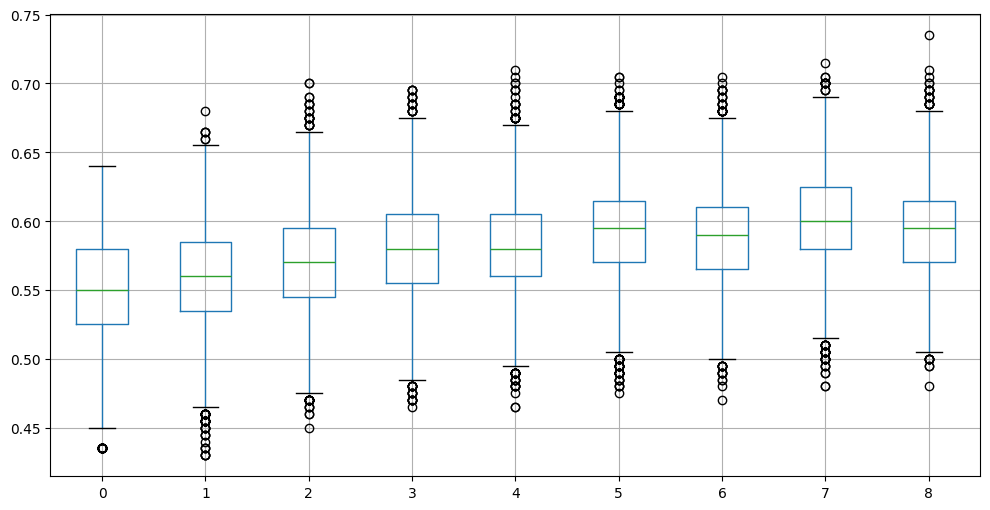

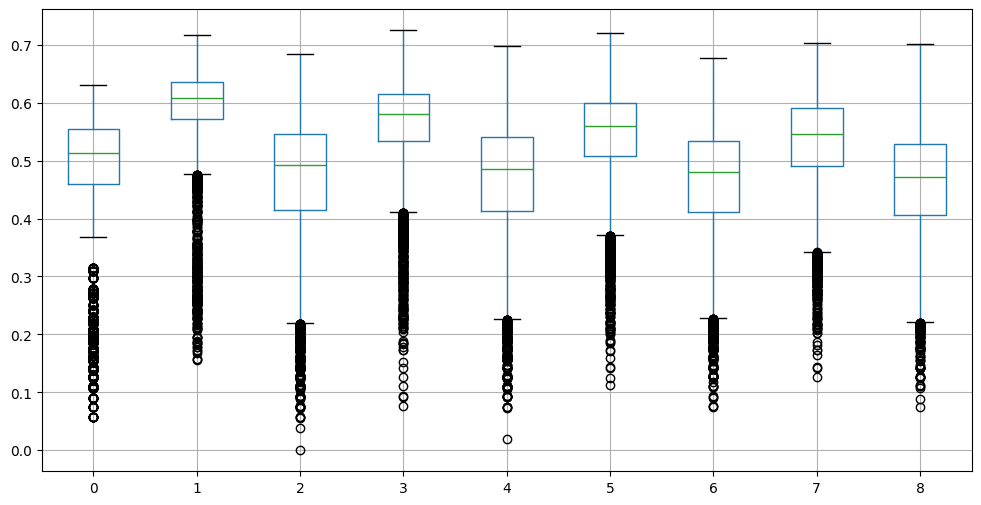

In [181]:
for data in [data_acc, data_f1]:
    df = pd.DataFrame(data).T
    display(df.describe().T.sort_values(by='mean', ascending=False).head(20))
    plt.figure()
    df.boxplot()

# Tunning 3 with search 2-4-6-trees

In [16]:
cls.drop_duplicated_trees()

15

In [60]:
cls

RandomForestMC(len(Forest)=369,n_trees=16,model_version=1.2.0-dev,module_version=1.2.0-dev)

In [75]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
cls_inc.setSoftVoting(True)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)
df_notfrauds = df_test.query(f'{target_col} == "0"').sample(n=1000).reset_index(drop=True)
df_mini_test = pd.concat([df_frauds, df_notfrauds], ignore_index=True)
y_test = df_mini_test[target_col].astype(int).to_list()

N_sim = 10000

data = defaultdict(list)
n_trees = [2, 4, 6]
for _ in tqdm(range(N_sim)):
    repated_forest = set()
    for i in n_trees:
        cls_inc.reset_forest()
        cls_inc.mergeForest(cls, N=i, by="random")
        hd5_forest = "".join(sorted([Tree.md5hexdigest for Tree in cls_inc]))
        if hd5_forest in repated_forest:
            continue
        repated_forest.add(hd5_forest)
        y_pred_soft = np.array(cls_inc.testForest(df_mini_test)).astype(int)
        acc = accuracy_score(y_test, y_pred_soft)
        f1 = f1_score(y_test, y_pred_soft)
        miss_rate = sum([not p for t, p in zip(y_test, y_pred_soft) if t]) / sum(y_test)
        for Tree in cls_inc:
            data[Tree.md5hexdigest].append((i, len(Tree.used_features), max(Tree.depths), acc, f1, miss_rate))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [76]:
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
dump_file_json(f"{dataset_path}/trees_metrcis_sim_{datetime_tag}.json", data)

In [77]:
len(data)

369

### Analysing the results

In [14]:
!ls $dataset_path/trees_metrcis_sim_*.json

/work/tmp/credit-card-fraud-prediction/trees_metrcis_sim_20240915_1425.json


In [15]:
data =  load_file_json('/work/tmp/credit-card-fraud-prediction/trees_metrcis_sim_20240915_1425.json')

In [29]:
md5_trees = list(data.keys())

In [32]:
columns = ['Forest Size','Feature Count','Max Depths','Acc','F1','Miss Rate']
list_trees = []
for md5_tree, stats_tree in data.items():
    df_stats = pd.DataFrame(data[md5_tree], columns=columns).max().to_frame().T
    df_stats['Tree'] = md5_tree
    list_trees.append(df_stats)
    df_stats = pd.DataFrame(data[md5_tree], columns=columns).mean().to_frame().T
    df_stats['Tree'] = md5_tree
    list_trees.append(df_stats)

df_trees = pd.concat(list_trees, ignore_index=True)
df_trees

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
0,6.000000,6.0,10.0,0.841818,0.303922,0.720000,08c1f734b5722a4f656b71574b520014
1,4.814570,6.0,10.0,0.641267,0.238503,0.395927,08c1f734b5722a4f656b71574b520014
2,6.000000,7.0,10.0,0.875455,0.284404,0.800000,d1ed637e494c7ba3d101f1d25d05144c
3,4.759740,7.0,10.0,0.605894,0.208976,0.439675,d1ed637e494c7ba3d101f1d25d05144c
4,6.000000,2.0,10.0,0.885455,0.350515,0.810000,ba3e97cf277d2c43ab104dc98ae3cb27
...,...,...,...,...,...,...,...
733,4.715232,7.0,14.0,0.731659,0.222758,0.581192,b4790d50a264e1a58396768400a7c916
734,6.000000,7.0,14.0,0.910000,0.367925,0.920000,812ec2c014a8b9403887c287e552aeba
735,4.726115,7.0,14.0,0.729108,0.227987,0.567580,812ec2c014a8b9403887c287e552aeba
736,6.000000,7.0,10.0,0.844545,0.316883,0.760000,82e3307c88b455f1189fac7352cc2ad2


In [33]:
df_trees.sort_values(by='F1', ascending=False).head(10)

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
70,6.0,9.0,10.0,0.889091,0.367925,0.83,168dec360450e0ceb46c015c1718eee7
586,6.0,12.0,15.0,0.907273,0.367925,0.88,f347bc86c5c66203e14d5819b0765bac
262,6.0,7.0,10.0,0.902727,0.367925,0.90,4ac91ff89873bc7de1337aea262ce9f4
372,6.0,8.0,10.0,0.886364,0.367925,0.87,5e0838119a1f1dbe52cbe84dd96b8632
734,6.0,7.0,14.0,0.910000,0.367925,0.92,812ec2c014a8b9403887c287e552aeba
176,6.0,10.0,15.0,0.903636,0.367925,0.92,6a84145d2994107aa850fdb0d981a41a
68,6.0,4.0,10.0,0.897273,0.350515,0.82,e7cda46edbfe578c01c35c6b515c63d9
4,6.0,2.0,10.0,0.885455,0.350515,0.81,ba3e97cf277d2c43ab104dc98ae3cb27
536,6.0,12.0,17.0,0.908182,0.350515,0.93,68b2d4b9ff54d22c924b0b98867bf89f
188,6.0,5.0,10.0,0.885455,0.350515,0.69,e4413276bcd7bc4acfda133c1d9569ba


In [35]:
df_trees.sort_values(by='Miss Rate').head(10)

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
379,4.658385,5.0,10.0,0.581570,0.221556,0.361988,bccc85e54753ddbb0ac2dceca9e2fcda
533,4.539877,7.0,10.0,0.601132,0.227985,0.364908,4f928b0e27b671542707487cf30b1d4c
161,4.650746,8.0,10.0,0.605948,0.229468,0.367522,478ced594396280e5d8ad3c780c0f30c
527,4.542056,4.0,10.0,0.607159,0.229653,0.369439,a527bfc1f423af37a3e8f8f76530dc4e
611,4.666667,4.0,10.0,0.612821,0.232432,0.371433,2fb8e6011eb2d194b25f6b266cdcfb13
687,4.835913,6.0,10.0,0.620594,0.236287,0.371858,be46a4358df0a1dc2e1f30318931c361
277,4.561728,5.0,11.0,0.589677,0.221185,0.372160,e032372b2a12fa8a78e21efe0fcc5666
471,4.714734,4.0,10.0,0.587985,0.219828,0.374232,a363d7b3cb8029910089ae93512c6bbd
609,4.716511,8.0,10.0,0.608023,0.227572,0.375794,eb610d4c57cfbf8213dda9057390bff1
21,4.727273,3.0,10.0,0.622866,0.233745,0.379560,8792856122d4c8a6f40e506616755376


<Axes: >

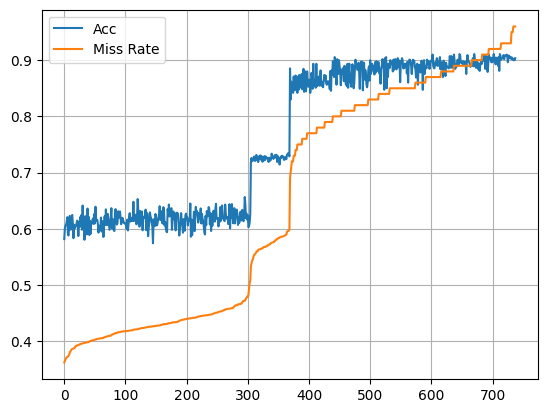

In [40]:
df_trees.sort_values(by='Miss Rate')[['Acc', 'Miss Rate']].reset_index(drop=True).plot(grid=True)

<Axes: >

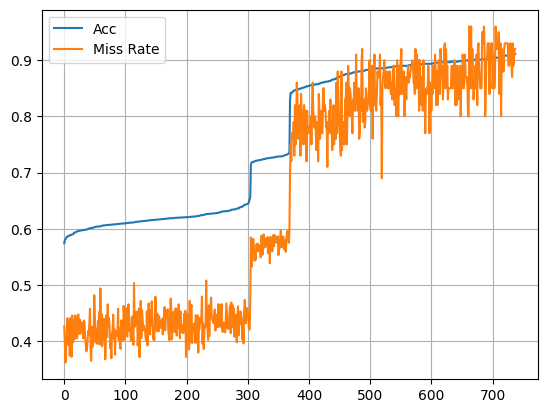

In [41]:
df_trees.sort_values(by='Acc')[['Acc', 'Miss Rate']].reset_index(drop=True).plot(grid=True)

<Axes: >

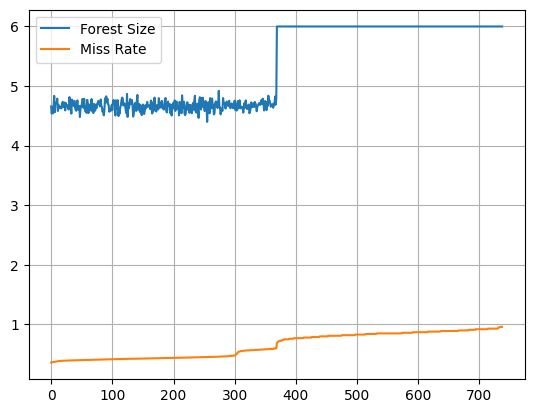

In [47]:
    df_trees.sort_values(by='Miss Rate')[['Forest Size', 'Miss Rate']].reset_index(drop=True).plot(grid=True)

<Axes: >

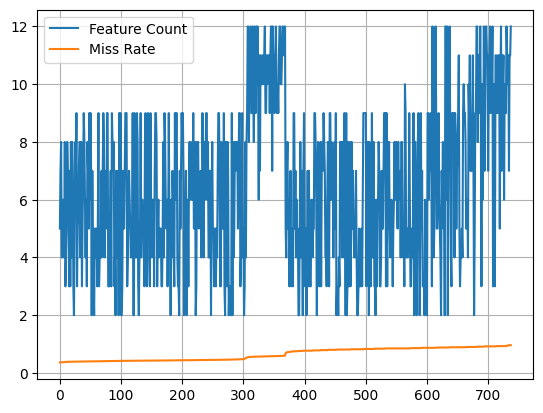

In [46]:
df_trees.sort_values(by='Miss Rate')[['Feature Count', 'Miss Rate']].reset_index(drop=True).plot(grid=True)

# Tuning 3

In [48]:
batch_train_pclass = split_schema['train']['1']
batch_val_pclass = split_schema['val']['1']
max_depth = None
n_trees = 256
max_discard_trees = 256
min_feature = 4
max_feature = 6

cpu_cores = 8
max_workers = 2*cpu_cores

cls = RandomForestMC(
    n_trees=n_trees, 
    target_col=target_col, 
    max_discard_trees=max_discard_trees,
    batch_train_pclass=batch_train_pclass,
    batch_val_pclass=batch_val_pclass,
    min_feature=min_feature,
    max_feature=max_feature,
    max_depth=max_depth
)
cls

RandomForestMC(len(Forest)=0,n_trees=256,model_version=1.2.0-dev,module_version=1.2.0-dev)

In [49]:
df_test = dfs['test']
y_test = df_test[target_col].astype(int).to_list()
ppy = lambda x: round(100*x, 6)

In [50]:
cls.fitParallel(dataset=df_tofit, max_workers=max_workers)
ModelDict = cls.model2dict()
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
path_dict = f'{dataset_path}/model_tuning3_{len(cls)}trees_{datetime_tag}.json'
dump_file_json(path_dict, ModelDict)
del ModelDict

Planting the forest:   0%|          | 0/256 [00:00<?, ?it/s]

In [51]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
f1_score_soft = f1_score(y_test, y_pred_soft)

print(f"{len(cls)} Trees")
cm = confusion_matrix(y_test, y_pred_soft)
display(pd.DataFrame(cm, columns=['Pred False','Pred True'], index=['False','True']))
tn, fp, fn, tp = cm.ravel()
obj_score = fn / (fn+tp)
print(f"Acc: {ppy(accuracy_soft):.4f}% \n F1: {ppy(f1_score_soft):.4f}% \n FN: {ppy(obj_score):.4f}%")

fc_stars, fc_list = cls.featCount()
print(f"Feat count stats: {fc_stars}")
Counter(fc_list).most_common()

256 Trees


,Pred False,Pred True
False,9287,713
True,55,45


Acc: 92.3960% 
 F1: 10.4895% 
 FN: 55.0000%
Feat count stats: (4.9921875, 0.8243946050549761, 4, 6)


[(4, 88), (6, 86), (5, 82)]

In [16]:
cls.drop_duplicated_trees()

15

In [60]:
cls

RandomForestMC(len(Forest)=369,n_trees=16,model_version=1.2.0-dev,module_version=1.2.0-dev)

In [52]:
cls_inc = RandomForestMC(target_col=target_col)
cls_inc.process_dataset(df_tofit)
cls_inc.setSoftVoting(True)
df_frauds = df_test.query(f'{target_col} == "1"').reset_index(drop=True)
df_notfrauds = df_test.query(f'{target_col} == "0"').sample(n=1000).reset_index(drop=True)
df_mini_test = pd.concat([df_frauds, df_notfrauds], ignore_index=True)
y_test = df_mini_test[target_col].astype(int).to_list()

N_sim = 10000

data = defaultdict(list)
n_trees = [2, 4, 6]
for _ in tqdm(range(N_sim)):
    repated_forest = set()
    for i in n_trees:
        cls_inc.reset_forest()
        cls_inc.mergeForest(cls, N=i, by="random")
        hd5_forest = "".join(sorted([Tree.md5hexdigest for Tree in cls_inc]))
        if hd5_forest in repated_forest:
            continue
        repated_forest.add(hd5_forest)
        y_pred_soft = np.array(cls_inc.testForest(df_mini_test)).astype(int)
        acc = accuracy_score(y_test, y_pred_soft)
        f1 = f1_score(y_test, y_pred_soft)
        miss_rate = sum([not p for t, p in zip(y_test, y_pred_soft) if t]) / sum(y_test)
        for Tree in cls_inc:
            data[Tree.md5hexdigest].append((i, len(Tree.used_features), max(Tree.depths), acc, f1, miss_rate))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [53]:
datetime_tag = datetime.now().strftime('%Y%m%d_%H%M')
dump_file_json(f"{dataset_path}/trees_metrcis_sim2_{datetime_tag}.json", data)

In [54]:
len(data)

256

### Analysing the results

In [56]:
!ls $dataset_path/trees_metrcis_sim2_*.json

/work/tmp/credit-card-fraud-prediction/trees_metrcis_sim2_20240915_1804.json


In [57]:
data =  load_file_json('/work/tmp/credit-card-fraud-prediction/trees_metrcis_sim2_20240915_1804.json')

In [58]:
md5_trees = list(data.keys())

In [59]:
columns = ['Forest Size','Feature Count','Max Depths','Acc','F1','Miss Rate']
list_trees = []
for md5_tree, stats_tree in data.items():
    df_stats = pd.DataFrame(data[md5_tree], columns=columns).max().to_frame().T
    df_stats['Tree'] = md5_tree
    list_trees.append(df_stats)
    df_stats = pd.DataFrame(data[md5_tree], columns=columns).mean().to_frame().T
    df_stats['Tree'] = md5_tree
    list_trees.append(df_stats)

df_trees = pd.concat(list_trees, ignore_index=True)
df_trees

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
0,6.000000,5.0,10.0,0.691818,0.266385,0.550000,e2458bfb7c4eb711aee354a8d3b35e76
1,4.721868,5.0,10.0,0.581397,0.204811,0.413248,e2458bfb7c4eb711aee354a8d3b35e76
2,6.000000,4.0,10.0,0.680909,0.280632,0.530000,5848b14eecff7d69996dce827c8e3d71
3,4.764706,4.0,10.0,0.570465,0.213118,0.366267,5848b14eecff7d69996dce827c8e3d71
4,6.000000,4.0,10.0,0.664545,0.257246,0.540000,1d7e41296e09d99b456ffca48b4e93a4
...,...,...,...,...,...,...,...
507,4.633947,4.0,10.0,0.549145,0.205307,0.366135,b5f6b0b210c7f1149a2751e560221757
508,6.000000,6.0,10.0,0.697273,0.269618,0.490000,980f3eabbf70787e37738525e15deb88
509,4.679406,6.0,10.0,0.585468,0.222772,0.352611,980f3eabbf70787e37738525e15deb88
510,6.000000,6.0,10.0,0.689091,0.281310,0.520000,7926a5ad0882f0eb0964afa0c4525d9b


In [60]:
df_trees.sort_values(by='F1', ascending=False).head(10)

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
130,6.0,5.0,10.0,0.680909,0.282398,0.55,899068e27f04228b4f52dbc58a1e8c5f
498,6.0,4.0,10.0,0.665455,0.282398,0.53,6b4c616142e0711204444e59ce59c89e
64,6.0,5.0,10.0,0.699091,0.282398,0.50,2f9b667293163cc66b34c5996ca98901
302,6.0,6.0,10.0,0.700909,0.282398,0.53,f5b903ef8cb6c5064a99f85322346a57
20,6.0,4.0,10.0,0.679091,0.282398,0.50,232839fcb6887e0612602921d94c0609
268,6.0,6.0,10.0,0.681818,0.282398,0.53,13b271f19d35decb08c41ea511e323f8
134,6.0,4.0,10.0,0.672727,0.281310,0.55,7a751f21b4a18903fe102c1285d28fe2
192,6.0,5.0,10.0,0.699091,0.281310,0.51,b0b42b676e0f552145af28bf55312e7e
238,6.0,5.0,10.0,0.680909,0.281310,0.52,0659596ea18a26ad82ae3b59c3e24e2e
500,6.0,5.0,10.0,0.696364,0.281310,0.53,a21b075f02f53ca95d861c3cd7541e1f


In [61]:
df_trees.sort_values(by='Miss Rate').head(10)

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree
481,4.674157,5.0,10.0,0.559005,0.223912,0.306854,19cd846f80c7d5b5c86d8131f8b08712
21,4.710280,4.0,10.0,0.568568,0.226154,0.312430,232839fcb6887e0612602921d94c0609
191,4.669421,5.0,10.0,0.567970,0.225255,0.314938,d3bd8aeebc1366c0cd9f963f5f496df2
175,4.490323,4.0,10.0,0.539079,0.214011,0.318065,c5f118b6d7311c8ab07c92acb95e0c51
137,4.655936,6.0,10.0,0.555939,0.218375,0.323159,abb80abde513085d949c289061ef35cc
385,4.745491,4.0,10.0,0.563053,0.221253,0.324008,e52f732f11e76ba91caf57a937bc580e
53,4.688889,6.0,10.0,0.569861,0.223531,0.324622,7fb4042e5c7dcc305c1d7e69735a7c22
273,4.723404,4.0,10.0,0.551696,0.216268,0.326000,1b11e49f821ce47140fd500ec2bc85eb
195,4.656716,5.0,10.0,0.576771,0.226326,0.326013,1b409156bf6b49e0729e881ab058a08c
67,4.696833,6.0,10.0,0.558007,0.218463,0.326697,260b42e1f4b0cbdf18f837f2dec9d292


In [63]:
df_trees['My Score'] = df_trees['Acc']-2*df_trees['Miss Rate']

In [65]:
df_trees.sort_values(by='My Score', ascending=False).head(10)

,Forest Size,Feature Count,Max Depths,Acc,F1,Miss Rate,Tree,My Score
303,4.675676,6.0,10.0,0.597934,0.230977,0.341081,f5b903ef8cb6c5064a99f85322346a57,0.256853
21,4.710280,4.0,10.0,0.568568,0.226154,0.312430,232839fcb6887e0612602921d94c0609,0.256138
191,4.669421,5.0,10.0,0.567970,0.225255,0.314938,d3bd8aeebc1366c0cd9f963f5f496df2,0.253032
481,4.674157,5.0,10.0,0.559005,0.223912,0.306854,19cd846f80c7d5b5c86d8131f8b08712,0.252151
195,4.656716,5.0,10.0,0.576771,0.226326,0.326013,1b409156bf6b49e0729e881ab058a08c,0.250758
421,4.577495,4.0,10.0,0.581617,0.226446,0.332866,566a254fd8e63364794a7890b95d3058,0.248751
363,4.502183,4.0,10.0,0.577132,0.225646,0.328406,0e95a857a707999485c6a1a6f05d94fe,0.248726
61,4.618421,6.0,10.0,0.581210,0.225954,0.333969,3ff11c60ae25bbc6231e2b1d796196ca,0.247241
275,4.565789,4.0,10.0,0.581673,0.226011,0.334474,923969425f7d0517bf13748c9708b480,0.247199
53,4.688889,6.0,10.0,0.569861,0.223531,0.324622,7fb4042e5c7dcc305c1d7e69735a7c22,0.245238


In [68]:
golden_trees = df_trees.sort_values(by='My Score', ascending=False).head(6).Tree.to_list()

In [72]:
cls.data = [Tree for Tree in cls.data if Tree.md5hexdigest in golden_trees]

In [73]:
cls

RandomForestMC(len(Forest)=6,n_trees=256,model_version=1.2.0-dev,module_version=1.2.0-dev)

# Generate the submission file

In [75]:
df_test = pd.read_csv(f'{dataset_path}/test.csv')
df_test = df_test.drop(columns='Time')
df_test['Transaction_Amount'] = (df_test['Transaction_Amount'] * 100).astype(np.uint32)
df_test

,id,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,Transaction_Amount
0,150000,-0.681234,-0.371212,0.385966,0.955703,2.064078,0.338827,-0.539452,-0.254046,0.010960,...,0.183560,-0.253324,0.266668,-0.153829,0.455969,-0.503628,0.257588,-0.456685,-0.298919,3042
1,150001,-1.098947,-0.959377,0.324934,0.703908,1.090582,-1.595909,0.584548,0.260069,0.057549,...,0.334764,0.130108,0.676928,-0.161070,-0.638011,-0.273424,0.711132,0.349967,0.141233,2300
2,150002,0.977029,-0.270984,0.471526,-1.232570,0.957537,-0.636602,-0.953060,-1.491744,0.226865,...,0.355728,0.517912,1.175087,-0.325895,-0.362636,0.306037,0.004828,0.037389,0.058222,19800
3,150003,1.176658,-0.225816,-0.246600,0.015513,1.103831,1.229516,-1.527098,-0.459769,0.749163,...,-0.152613,-0.104600,0.003800,-0.023180,-0.458338,0.481427,-0.381415,0.080165,0.027372,999
4,150004,0.804828,-0.272967,0.959910,-1.117567,0.395748,0.589855,1.059880,-1.101203,0.066464,...,-0.127818,-0.011849,0.078540,-0.241700,0.010130,0.302614,-0.259568,0.023127,0.056957,23900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69124,219124,1.891079,-0.041423,0.858158,-1.272908,-3.783908,-1.388939,-0.280639,2.012789,2.666080,...,-0.195703,-0.181369,-0.456538,-0.069571,0.756765,0.244479,-0.147566,-0.054725,-0.044588,19865
69125,219125,0.139724,-0.917395,-0.257933,0.948649,-2.913655,-2.184829,-0.457534,1.883716,-1.056824,...,-0.116538,0.491469,1.478823,-0.085398,-0.091409,-1.053488,0.467570,0.358918,0.294735,2400
69126,219126,2.058343,0.391801,-0.136498,-0.038993,-1.928553,0.330117,0.179926,0.270127,-0.735664,...,-0.384830,-0.306640,-0.965783,0.307799,-0.021434,-0.343989,0.181065,-0.098387,-0.044064,179
69127,219127,2.079227,0.301966,1.536193,-2.162389,-1.785833,-2.804889,-0.058879,0.552845,4.038013,...,-0.190984,0.109909,0.590401,0.286621,0.675660,-0.510736,-0.090044,0.056749,-0.017126,8800


In [77]:
df_id = df_test['id'].to_frame()
df_test = df_test.drop(columns=['id'])

In [79]:
cls.setSoftVoting()
y_pred_soft = np.array(cls.testForest(df_test)).astype(int)

In [82]:
!head $dataset_path/sample_submission.csv

id,IsFraud
150000,0.5
150001,0.5
150002,0.5
150003,0.5
150004,0.5
150005,0.5
150006,0.5
150007,0.5
150008,0.5


In [83]:
df_id['IsFraud'] = y_pred_soft
df_id

,id,IsFraud
0,150000,0
1,150001,0
2,150002,1
3,150003,1
4,150004,0
...,...,...
69124,219124,0
69125,219125,1
69126,219126,0
69127,219127,0


In [86]:
df_id.to_csv(f'{dataset_path}/submission_exp1.csv', index=False)

In [87]:
!head $dataset_path/submission_exp1.csv

id,IsFraud
150000,0
150001,0
150002,1
150003,1
150004,0
150005,0
150006,0
150007,1
150008,0


# Kagle results

Private Score: `0.53218`  (1st: `0.80611`)  
Public Score: `0.59206`  (1st: `0.83947`)  